In [1]:
from faker import Faker
import numpy as np
from datetime import datetime, timedelta

Constantes: tamanho do Mock e instância do Faker

In [2]:
USER_COUNT = 5291
TRANSFER_COUNT = 5291 * 3
fake = Faker()

# Dados de Usuário

Gerando IDs

In [3]:
users = list()
for i in range(USER_COUNT):
    new_user = dict()
    new_user['id'] = fake.uuid4()
    users.append(new_user)

Gerando *created_at* e *updated_at*

In [4]:
for i in range(USER_COUNT):
    # 6 months ago as the start date
    start_date = datetime.now() - timedelta(days=180)
    # 01/07/2023 as the end date
    end_date = datetime(2023, 7, 1)
    # random date between start_date and end_date
    new_c_at = fake.date_time_between(start_date=start_date, end_date=end_date)
    # to iso string
    users[i]['created_at'] = new_c_at.isoformat()
    # updated_at between created_at and 01/07/2023
    new_u_at = fake.date_time_between(start_date=new_c_at, end_date=end_date)
    users[i]['updated_at'] = new_u_at.isoformat()

Gerando datas de nascimento

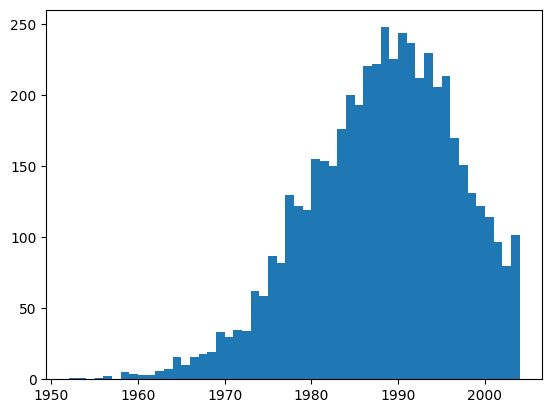

In [41]:
from matplotlib import pyplot as plt
from scipy.stats import skewnorm


random_years = skewnorm.rvs(a=-1.5, loc=1996, scale=12, size=USER_COUNT)
random_years = np.round(random_years, 0).astype(int)
random_years = np.minimum(random_years, 2005)
# Count the number of users created in each year
# Year is x axis, count is y axis
minimum_year = np.min(random_years)
maximum_year = np.max(random_years)
plt.hist(random_years, bins=range(minimum_year, maximum_year))
plt.show()

In [6]:
for i in range(USER_COUNT):
    random_date = fake.date(pattern='%m-%d')
    random_date_with_year = f'{random_years[i]}-{random_date}'
    users[i]['birthday'] = random_date_with_year


In [7]:
import pandas as pd

pd.DataFrame(users).to_csv('users.csv', index=False)

# Endereços

Utilizando .csv de municipios contidos [aqui](http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista_Munic%C3%ADpios_com_IBGE_Brasil_Versao_CSV.csv)

In [8]:
# Renomeie o CSV
municipios = pd.read_csv('municipios.csv', sep=';')
# Ignorando duas colunas
municipios = municipios.drop(columns=['ConcatUF+Mun', 'Unnamed: 9']).sort_values(by=['População 2010'], ascending=False)
# Ignorando munícipios sem informação de população
municipios = municipios.dropna(subset=['População 2010'])
display(municipios.head(20))

,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
3827,355030,3550308,SP,São Paulo,Região Sudeste,11253503.0,Metrópole,Capital
3240,330455,3304557,RJ,Rio de Janeiro,Região Sudeste,6320446.0,Metrópole,Capital
2160,292740,2927408,BA,Salvador,Região Nordeste,2675656.0,Metrópole,Capital
5567,530010,5300108,DF,Brasília,Região Centro-Oeste,2570160.0,Metrópole,Capital
947,230440,2304400,CE,Fortaleza,Região Nordeste,2452185.0,Metrópole,Capital
2307,310620,3106200,MG,Belo Horizonte,Região Sudeste,2375151.0,Metrópole,Capital
109,130260,1302603,AM,Manaus,Região Norte,1802014.0,Metrópole,Capital
4003,410690,4106902,PR,Curitiba,Região Sul,1751907.0,Metrópole,Capital
1594,261160,2611606,PE,Recife,Região Nordeste,1537704.0,Metrópole,Capital
4929,431490,4314902,RS,Porto Alegre,Região Sul,1409351.0,Metrópole,Capital


(array([3503.,  587.,  364.,  253.,  190.,  112.,  102.,   75.,   65.,
          40.]),
 array([   0. ,  555.7, 1111.4, 1667.1, 2222.8, 2778.5, 3334.2, 3889.9,
        4445.6, 5001.3, 5557. ]),
 <BarContainer object of 10 artists>)

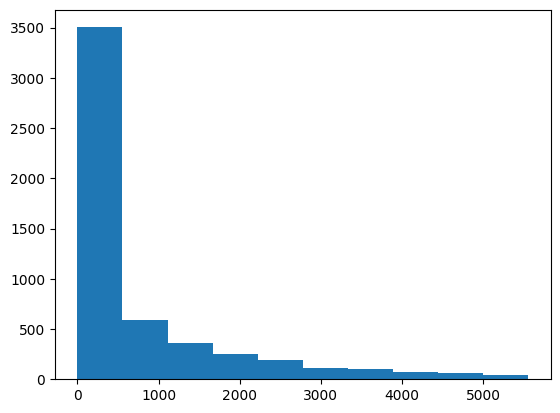

In [9]:
from matplotlib import pyplot as plt
import numpy as np

random_idx = np.random.choice(len(municipios), size=USER_COUNT, p=municipios['População 2010'].values / np.sum(municipios['População 2010'].values))
# Count the number of users created in each year
# Year is x axis, count is y axis
plt.hist(random_idx)

In [10]:
users_adresses = list()
for i in range(USER_COUNT):
    new_address = dict()
    new_address['owner_id'] = users[i]['id']
    new_address['city'] = municipios.iloc[random_idx[i]]['Município']
    new_address['state'] = municipios.iloc[random_idx[i]]['UF']
    users_adresses.append(new_address)

In [11]:
import pandas as pd

pd.DataFrame(users_adresses).to_csv('addresses.csv', index=False)

# Transferências

Nesse caso, não incluiremos ID de conta. Referenciaremos diretamente o usuário dono da conta.

Valor mínimo: 0.0
Valor máximo: 4571.98


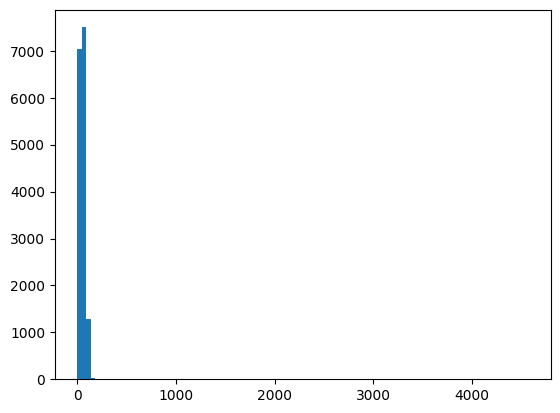

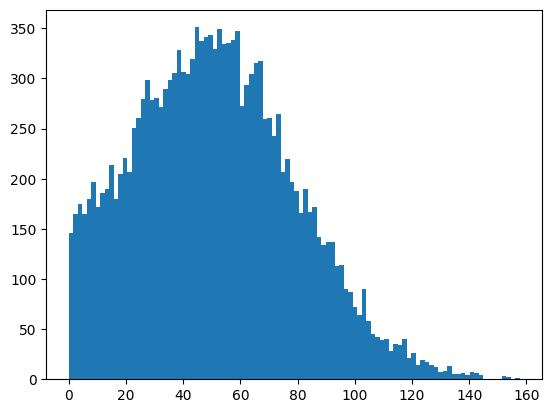

In [33]:
import numpy as np
from matplotlib import pyplot as plt

# Valores das transferências
values = np.random.normal(loc=50, scale=30, size=TRANSFER_COUNT - 25)
# Adicionando 25 outliers
values = np.append(values, np.random.normal(loc=3000, scale=1000, size=25))
# Valores negativos não fazem sentido nesse caso, aplicando módulo
values = np.abs(values)
# 2 casas decimais
values = np.round(values, 2)
print(f'Valor mínimo: {np.min(values)}')
print(f'Valor máximo: {np.max(values)}')
plt.hist(np.sort(values), bins=100)
plt.show()
plt.hist(np.sort(values)[:-25], bins=100)
plt.show()

In [38]:
transfers = list()
# Transferência não precisa ter ID
# Apenas: Valor, status, created_at/updated_at e time_to_transfer (caso seja agendada)
# Precisa de um ID do usuário de origem e um ID do usuário de destino
# Esses são escolhidos aleatoriamente
for i in range(TRANSFER_COUNT):
    new_transfer = dict()
    nt_id_from = np.random.choice(USER_COUNT)
    nt_id_to = np.random.choice(USER_COUNT)
    # created_at lower bound
    user_from = users[nt_id_from]
    user_to = users[nt_id_to]
    # created_at lower bound is defined by which user was created last
    lower_bound = datetime.fromisoformat(user_from['created_at']) if datetime.fromisoformat(
        user_from['created_at']) > datetime.fromisoformat(user_to['created_at']) else datetime.fromisoformat(user_to['created_at'])
    # upper_bound is the day 01/07/2023
    upper_bound = datetime(2023, 7, 1)
    nt_created_at = fake.date_time_between(
        start_date=lower_bound, end_date=upper_bound)
    new_transfer['created_at'] = nt_created_at.isoformat()
    new_transfer['value'] = values[i]
    nt_status = np.random.choice(
        ['FAILED', 'DONE', 'SCHEDULED'], p=[0.025, 0.6, 0.375])
    if nt_status != 'FAILED':
        new_transfer['updated_at'] = nt_created_at.isoformat()
    if nt_status == 'SCHEDULED':
        # add one day to created_at
        start_date = nt_created_at + timedelta(days=1)
        nt_time_to_transfer = fake.date_between(
            start_date=nt_created_at, end_date=upper_bound)
        new_transfer['time_to_transfer'] = nt_time_to_transfer.isoformat()
    else:
        new_transfer['time_to_transfer'] = None
    new_transfer['status'] = nt_status
    new_transfer['id_from'] = user_from['id']
    new_transfer['id_to'] = user_to['id']
    transfers.append(new_transfer)

In [40]:
import pandas as pd

pd.DataFrame(transfers).to_csv('transfers.csv', index=False)

Mock parece ok. Porém, falta uma coisa:

<span style="color:red">Garantir que os usuários sejam criados de forma igualitária entre os últimos 6 meses.</span>